<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/PSW%2BSMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- 0. 导入库 ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# 用于倾向评分估计 & 平衡表
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances


In [ ]:
# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [ ]:
# ==== 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [ ]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [ ]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [ ]:
# 查看族裔变量的原始分布
df_model["ethn_participant"].value_counts(dropna=False)


,count
ethn_participant,
1,156
3,76
7,33
2,13
4,10
5,8
6,6
8,4
9,2


In [ ]:
# 根据 BiB 文献做的三类
df_model["ethnicity3"] = df_model["ethn_participant"].replace({
    1: "White British",
    3: "Pakistani"
})
df_model["ethnicity3"] = df_model["ethnicity3"].where(
    df_model["ethnicity3"].isin(["White British", "Pakistani"]), "Other"
)

df_model["ethnicity3"].value_counts()


,count
ethnicity3,
White British,156
Other,76
Pakistani,76


In [ ]:
# 检查主要分析变量缺失
main_vars = [
    "HFI_binary", "weighted_upf_percent",
    "gender_participant", "age_participant", "ethnicity3"
]

missing_info = {}
for col in main_vars:
    n_miss = df_model[col].isna().sum()
    missing_info[col] = n_miss

df_main = df_model[main_vars].dropna().copy()
print("主分析样本量:", len(df_main))

主分析样本量: 308


# 建模

## 0) 预备：映射族裔（WB / PK / Mixed），构建两套数据集

In [55]:
import numpy as np, pandas as pd

df = df_model.copy()
eth_map = {1:"White British", 3:"Pakistani", 7:"Mixed"}
df["ethnicity3"] = df["ethn_participant"].map(eth_map).fillna("Other")

core_vars = ["HFI_binary","weighted_upf_percent","age_participant","gender_participant","ethnicity3"]
ses_vars  = core_vars + ["income","employ"]

df_core = (df.loc[df["ethnicity3"].isin(["White British","Pakistani","Mixed"]), core_vars]
             .dropna().copy())
df_ses  = (df.loc[df["ethnicity3"].isin(["White British","Pakistani","Mixed"]), ses_vars]
             .dropna().copy())

print("Core n=", len(df_core), df_core["ethnicity3"].value_counts().to_dict())
print("SES  n=", len(df_ses),  df_ses["ethnicity3"].value_counts().to_dict())


Core n= 265 {'White British': 156, 'Pakistani': 76, 'Mixed': 33}
SES  n= 261 {'White British': 154, 'Pakistani': 75, 'Mixed': 32}


### 1) 描述性统计（Table 1 原材料）

In [56]:
from scipy import stats

def cat_table(df, by):
    out=[]
    for c in ["gender_participant","ethnicity3","HFI_binary"]:
        ct = pd.crosstab(df[c], df[by])
        if ct.shape[1]==2:
            chi2,p,_,_ = stats.chi2_contingency(ct)
        else:
            chi2,p = np.nan,np.nan
        out.append((c, ct, p))
    return out

def cont_table(df, cont_cols, by):
    out=[]
    for c in cont_cols:
        g0 = df.loc[df[by]==0, c].dropna()
        g1 = df.loc[df[by]==1, c].dropna()
        # 非正态常用 WMW
        stat,p = stats.mannwhitneyu(g0, g1, alternative="two-sided")
        out.append((c, g0.median(), g1.median(), np.median(df[c]), p))
    return out

cats = cat_table(df_core, "HFI_binary")
conts= cont_table(df_core, ["weighted_upf_percent","age_participant"], "HFI_binary")

for c,ct,p in cats:
    print(f"\n{c}\n", ct, "\nchi2 p=", round(p,4))
print("\nContinuous (median in HFI=0 / HFI=1 / overall, WMW p):")
for c,m0,m1,mo,p in conts:
    print(f"{c}: {m0:.2f} / {m1:.2f} / {mo:.2f}  p={p:.4f}")



gender_participant
 HFI_binary          0.0  1.0
gender_participant          
1                    91   39
2                    94   41 
chi2 p= 1.0

ethnicity3
 HFI_binary     0.0  1.0
ethnicity3             
Mixed           22   11
Pakistani       47   29
White British  116   40 
chi2 p= 0.137

HFI_binary
 HFI_binary  0.0  1.0
HFI_binary          
0.0         185    0
1.0           0   80 
chi2 p= 0.0

Continuous (median in HFI=0 / HFI=1 / overall, WMW p):
weighted_upf_percent: 70.22 / 72.65 / 70.86  p=0.4481
age_participant: 7.00 / 7.50 / 7.00  p=0.1892


## 1) 工具函数：PSW、SMD 平衡表

In [64]:
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf

import numpy as np
import pandas as pd

def _smd_mean_diff(x, treat, w=None):
    """
    Standardized mean difference:
    (mean1 - mean0) / pooled SD, supports optional weights.
    x, treat, w are 1-D numpy arrays of same length.
    """
    x = np.asarray(x, dtype=float)
    t = np.asarray(treat, dtype=int)
    if w is None:
        w = np.ones_like(x, dtype=float)
    else:
        w = np.asarray(w, dtype=float)
        assert len(w) == len(x), "weights length must match x"

    # weighted means
    m1 = np.average(x[t==1], weights=w[t==1])
    m0 = np.average(x[t==0], weights=w[t==0])
    # pooled (weighted) SD
    v1 = np.average((x[t==1]-m1)**2, weights=w[t==1])
    v0 = np.average((x[t==0]-m0)**2, weights=w[t==0])
    s  = np.sqrt((v1 + v0)/2.0 + 1e-9)
    return (m1 - m0) / s

def balance_table(df_in, covs, treat_col="HFI_binary", sw=None):
    """
    Build a covariate balance table with SMD before/after weighting.
    - df_in: the dataframe to evaluate (e.g., df_core or df_ses)
    - covs: list of covariate column names
    - treat_col: treatment indicator column in df_in
    - sw: weights aligned to df_in (same length); if None, only unweighted SMD
    """
    df_in = df_in.copy()
    t = df_in[treat_col].astype(int).values

    if sw is None:
        w_w = None
    else:
        w_w = np.asarray(sw, dtype=float)
        assert len(w_w) == len(df_in), "weights length must match df_in length"

    rows = []
    for c in covs:
        s_unw = []
        s_w   = []

        col = df_in[c]
        # categorical -> dummies (no drop_first so each level assessed)
        if col.dtype == "O" or str(col.dtype).startswith("category"):
            d = pd.get_dummies(col, drop_first=False)
            for k in d.columns:
                x = d[k].values.astype(float)
                smd_unw = _smd_mean_diff(x, t, w=None)
                smd_w   = _smd_mean_diff(x, t, w_w) if w_w is not None else np.nan
                rows.append([f"{c}={k}", smd_unw, smd_w])
        else:
            x = col.values.astype(float)
            smd_unw = _smd_mean_diff(x, t, w=None)
            smd_w   = _smd_mean_diff(x, t, w_w) if w_w is not None else np.nan
            rows.append([c, smd_unw, smd_w])

    tab = pd.DataFrame(rows, columns=["Covariate","SMD (unweighted)","SMD (PSW)"])
    return tab



### 3) 未调整模型（便于对照）

In [65]:
m_unadj = smf.ols("weighted_upf_percent ~ HFI_binary", data=df_core).fit(cov_type="HC3")
print(m_unadj.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     69.2491      0.924     74.924      0.000      67.438      71.061
HFI_binary     1.1870      1.671      0.711      0.477      -2.087       4.461


#  Core-A：主效应（PSW + HC3）+ 调整均值 Δpp & CI

In [66]:
# PSW（人口学）
sw_core, ps_core, _ = fit_ps_and_sw(df_core, ["age_participant","gender_participant","ethnicity3"])

# 主效应：WLS(+HC3)
m_coreA = smf.wls("weighted_upf_percent ~ HFI_binary",
                  data=df_core, weights=sw_core).fit(cov_type="HC3")
d_coreA = m_coreA.params["HFI_binary"]
ci_coreA = m_coreA.conf_int().loc["HFI_binary"].tolist()
print(f"[Core-A PSW] Δ = {d_coreA:.2f} pp (95% CI {ci_coreA[0]:.2f}, {ci_coreA[1]:.2f})")

# 平衡表（人口学）
bal = balance_table(df_core, ["age_participant","gender_participant","ethnicity3"], sw=sw_core)
bal


[Core-A PSW] Δ = 1.83 pp (95% CI -1.45, 5.10)


,Covariate,SMD (unweighted),SMD (PSW)
0,age_participant,0.168897,-0.017310
1,gender_participant,0.008786,0.001347
2,ethnicity3=Mixed,0.055600,0.003244
3,ethnicity3=Pakistani,0.236478,0.004620
4,ethnicity3=White British,-0.258255,-0.006417


 # Core-B：交互（HFI × Ethnicity3）+ 族群内 Δ

In [67]:
m_coreB = smf.wls("weighted_upf_percent ~ HFI_binary * C(ethnicity3)",
                  data=df_core, weights=sw_core).fit(cov_type="HC3")
print(m_coreB.summary().tables[1])

rows=[]
for g in ["White British","Pakistani","Mixed"]:
    sub = df_core[df_core["ethnicity3"]==g].copy()
    swg = sw_core[df_core["ethnicity3"]==g]
    mm = smf.wls("weighted_upf_percent ~ HFI_binary", data=sub, weights=swg).fit(cov_type="HC3")
    lo, hi = mm.conf_int().loc["HFI_binary"].tolist()
    rows.append([g, mm.params["HFI_binary"], lo, hi])
coreB_by_eth = pd.DataFrame(rows, columns=["Ethnicity","Δ (pp)","95% CI lower","95% CI upper"]).round(2)
coreB_by_eth


                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    66.1332      2.944     22.466      0.000      60.364      71.903
C(ethnicity3)[T.Pakistani]                   -1.3195      3.502     -0.377      0.706      -8.184       5.545
C(ethnicity3)[T.White British]                5.7143      3.138      1.821      0.069      -0.436      11.864
HFI_binary                                    8.2725      4.933      1.677      0.094      -1.396      17.941
HFI_binary:C(ethnicity3)[T.Pakistani]        -6.9849      5.687     -1.228      0.219     -18.132       4.162
HFI_binary:C(ethnicity3)[T.White British]    -7.5063      5.408     -1.388      0.165     -18.106       3.094


,Ethnicity,Δ (pp),95% CI lower,95% CI upper
0,White British,0.77,-3.58,5.11
1,Pakistani,1.29,-4.26,6.84
2,Mixed,8.27,-1.40,17.94


# SES 解释性（把收入做非线性；❶“小而强”之二）

In [68]:
# 收入非线性：五分位（根据你实际变量分布可调）
try:
    df_ses = df_ses.copy()
    df_ses["income_q"] = pd.qcut(df_ses["income"].rank(method="first"), 5, labels=[f"Q{i}" for i in range(1,6)])
    X_ses = ["age_participant","gender_participant","ethnicity3","income_q","employ"]
except Exception as e:
    print("qcut 失败，退回把 income 当作分类：", e)
    df_ses["income_q"] = df_ses["income"].astype(str)
    X_ses = ["age_participant","gender_participant","ethnicity3","income_q","employ"]

sw_ses, ps_ses, _ = fit_ps_and_sw(df_ses, X_ses)

m_ses = smf.wls("weighted_upf_percent ~ HFI_binary",
                data=df_ses, weights=sw_ses).fit(cov_type="HC3")
d_ses = m_ses.params["HFI_binary"]; ci_ses = m_ses.conf_int().loc["HFI_binary"].tolist()
atten = (d_coreA - d_ses)/d_coreA*100 if d_coreA!=0 else np.nan

print(f"[SES-PSW] Δ = {d_ses:.2f} pp (95% CI {ci_ses[0]:.2f}, {ci_ses[1]:.2f});  Attenuation = {atten:.1f}%")

# SES 平衡表（增加 income_q 与 employ）
bal_ses = balance_table(df_ses, ["age_participant","gender_participant","ethnicity3","income_q","employ"], sw=sw_ses)
bal_ses


[SES-PSW] Δ = 2.39 pp (95% CI -1.21, 5.99);  Attenuation = -30.8%


,Covariate,SMD (unweighted),SMD (PSW)
0,age_participant,0.154946,0.010094
1,gender_participant,0.023980,0.025949
2,ethnicity3=Mixed,0.024216,0.029218
3,ethnicity3=Pakistani,0.222636,0.021332
4,ethnicity3=White British,-0.223706,-0.039300
5,income_q=Q1,0.806656,0.272677
6,income_q=Q2,0.330202,0.043651
7,income_q=Q3,-0.606434,-0.230439
8,income_q=Q4,-0.266678,0.024363
9,income_q=Q5,-0.427290,-0.143307


# 7) 稳健性

In [69]:
# 7.1 HFI 三分类趋势（若已有 HFI_3cat=0/1/2）
# if "HFI_3cat" in df_core.columns:
#     m_trend = smf.wls("weighted_upf_percent ~ HFI_3cat", data=df_core, weights=sw_core).fit(cov_type="HC3")
#     print(m_trend.summary())

# 7.2 分位数回归（中位数；未加权版本）
import statsmodels.api as sm
qr = sm.QuantReg(df_core["weighted_upf_percent"],
                 sm.add_constant(df_core[["HFI_binary","age_participant"]]))
print(qr.fit(q=0.5).summary())


                          QuantReg Regression Results                           
Dep. Variable:     weighted_upf_percent   Pseudo R-squared:             0.005842
Model:                         QuantReg   Bandwidth:                       9.681
Method:                   Least Squares   Sparsity:                        32.17
Date:                  Thu, 14 Aug 2025   No. Observations:                  265
Time:                          03:19:14   Df Residuals:                      262
                                          Df Model:                            2
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              68.4358      2.841     24.089      0.000      62.842      74.030
HFI_binary          2.0044      2.159      0.928      0.354      -2.247       6.256
age_participant     0.3357      0.380      0.884      0.377      -0.412       1.083


# 8) 作图（Figure 1 / 2）

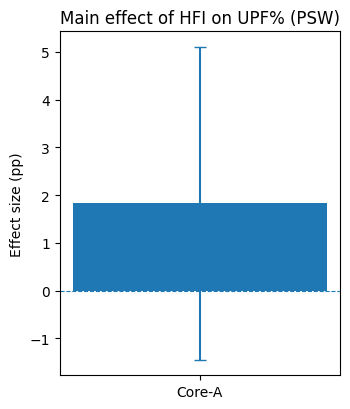

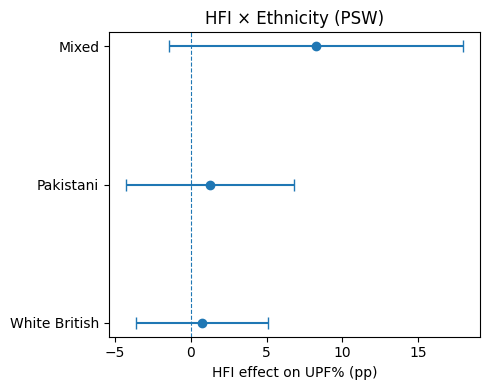

In [70]:
import matplotlib.pyplot as plt

# Fig1: Core-A
fig, ax = plt.subplots(figsize=(3.6,4.2))
ax.bar(0, d_coreA)
ax.errorbar(0, d_coreA, yerr=[[d_coreA-ci_coreA[0]],[ci_coreA[1]-d_coreA]], fmt='none', capsize=4)
ax.axhline(0, ls='--', lw=0.8)
ax.set_xticks([0]); ax.set_xticklabels(["Core-A"])
ax.set_ylabel("Effect size (pp)")
ax.set_title("Main effect of HFI on UPF% (PSW)")
plt.tight_layout(); plt.show()

# Fig2: Core-B（WB/PK/Mixed）
fig, ax = plt.subplots(figsize=(5,4))
ax.errorbar(coreB_by_eth["Δ (pp)"], coreB_by_eth["Ethnicity"],
            xerr=[coreB_by_eth["Δ (pp)"]-coreB_by_eth["95% CI lower"],
                  coreB_by_eth["95% CI upper"]-coreB_by_eth["Δ (pp)"]],
            fmt='o', capsize=4)
ax.axvline(0, ls='--', lw=0.8)
ax.set_xlabel("HFI effect on UPF% (pp)")
ax.set_title("HFI × Ethnicity (PSW)")
plt.tight_layout(); plt.show()


# 9) 主结果表（Table 2）

In [71]:
def pretty_ci(est, ci): return f"{est:.2f} ({ci[0]:.2f}, {ci[1]:.2f})"

table2 = pd.DataFrame([
    ["Core-A (PSW, adj. demographics)", d_coreA,  *ci_coreA],
    ["Core-B: White British",          *coreB_by_eth.set_index("Ethnicity").loc["White British", ["Δ (pp)","95% CI lower","95% CI upper"]].tolist()],
    ["Core-B: Pakistani",              *coreB_by_eth.set_index("Ethnicity").loc["Pakistani",     ["Δ (pp)","95% CI lower","95% CI upper"]].tolist()],
    ["Core-B: Mixed",                  *coreB_by_eth.set_index("Ethnicity").loc["Mixed",         ["Δ (pp)","95% CI lower","95% CI upper"]].tolist()],
    ["Sens-SES (PSW + income_q + employ)", d_ses, *ci_ses]
], columns=["Model","Δ (pp)","95% CI lower","95% CI upper"]).round(2)

table2["Effect size (pp) [95% CI]"] = table2.apply(lambda r: pretty_ci(r["Δ (pp)"], [r["95% CI lower"], r["95% CI upper"]]), axis=1)
table2[["Model","Effect size (pp) [95% CI]"]]


,Model,Effect size (pp) [95% CI]
0,"Core-A (PSW, adj. demographics)","1.83 (-1.45, 5.10)"
1,Core-B: White British,"0.77 (-3.58, 5.11)"
2,Core-B: Pakistani,"1.29 (-4.26, 6.84)"
3,Core-B: Mixed,"8.27 (-1.40, 17.94)"
4,Sens-SES (PSW + income_q + employ),"2.39 (-1.21, 5.99)"
